In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import json
from scipy.signal import argrelextrema
from scipy import ndimage
import ast

In [ ]:
from data_preprocess import Preprocessor
prepro = Preprocessor("cf_data.csv")
prepro.remove_small_classes(10)
joints_array = prepro.get_coord_arr()
print(joints_array.shape)

release = prepro.get_release_frame(60,120)
assert(len(release)==len(joints_array))
files_csv = prepro.cf["play_id"].values
assert(len(files_csv)==len(joints_array))

In [ ]:
just_max = []
with_grad = []
with_surrounding_grad = []
higher_shoulders = []

surround_range = 5
joints_list = ["right_shoulder", "left_shoulder", "right_elbow", "right_wrist","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck ",
            "right_eye", "right_ear","left_eye", "left_ear"]
smooth_all = ndimage.filters.gaussian_filter1d(joints_array, axis=1, sigma = 3)
grad_all = np.gradient(smooth_all, axis=1)

nr = 50
for j in range(nr): #len(joints_array)):
    print(files_csv[j])
    print("truth:", release[j])
    right_wrist = joints_array[j,:,3,0]

    # just_max
    just_max.append(np.argmin(right_wrist))
    highest_ind = np.array(argrelextrema(right_wrist, np.less))[0] # np.argsort(right_wrist)
    highest = highest_ind[np.argsort(right_wrist[highest_ind])]
    print("min", np.argmin(right_wrist), "argsort", np.argsort(right_wrist)[:5], "argextrema", highest[:5])

    # with_grad:
    smooth = ndimage.filters.gaussian_filter1d(right_wrist, sigma = 3)
    grad = np.gradient(smooth)
    grad2 = np.gradient(np.gradient(smooth))
    # maxima = argrelextrema(grad, np.greater)
    # minima = argrelextrema(grad, np.less)
    extrema = np.where((grad2[:-1] * grad2[1:]) < 0)[0]
    #print(extrema)
    for i in range(5):
        if np.sum(np.absolute(highest[i]-extrema)<10)>1:
            #print("found")
            #print(highest[-i])
            with_grad.append(highest[i])
            #print("differences", np.absolute(highest[-i]-extrema))
            #print("smaller5:", np.sum(np.absolute(highest[-i]-extrema)<10))
            break
        else:
            #print("not found")
            if i==4:
                with_grad.append(0)
        #print(highest[-i])
        #print("differences", np.absolute(highest[-i]-extrema))
        #print("smaller5:", np.sum(np.absolute(highest[-i]-extrema)<10))

    # surrounding_grad:
    highest_5 = list(highest_ind) #[-4:])
    highest_5.append(np.argmin(right_wrist))
    # print("highest_indizes", highest_5)
    surrounding_grad = []
    for i in range(len(highest_5)):
        if highest_5[i]<5 or highest_5[i]>160:
            surrounding_grad.append(0)
        else:
            up_down_grad = - np.mean(grad[highest_5[i]-surround_range:highest_5[i]])+ np.mean(grad[highest_5[i]:highest_5[i]+surround_range])
            surr_five_grad = np.mean(np.absolute(grad[highest_5[i]-5:highest_5[i]+5]))
            surrounding_grad.append(up_down_grad)
    print("surrounding_grad", highest_5[np.argmax(surrounding_grad)])
    with_surrounding_grad.append(highest_5[np.argmax(surrounding_grad)])

    # higher shoulders:
    wrist_ellbow_right = np.mean(joints_array[j, :, 2:4, 0], axis = 1) # y coordinate of ellbow and wrist
    wrist_ellbow_left = np.mean(joints_array[j, :, 4:6, 0], axis = 1)
    shoulders = np.mean(joints_array[j,: ,:2,0], axis = 1) # y coordinate of shoulders
    if min(wrist_ellbow_right-shoulders)<min(wrist_ellbow_left-shoulders):
        higher = np.argmin(wrist_ellbow_right-shoulders)
        print("higher shoulders right", higher)
    else:
        higher = np.argmin(wrist_ellbow_left-shoulders)
        print("higher shoulders left", higher)

    higher_shoulders.append(higher)



    if abs(release[j]-higher)>3:
        # Plotting
        fig = plt.figure(figsize = (20,10))
        #for i in range(12):
         #   plt.plot(joints_array[j,:,i,0], label = joints_list[i]) #, joints_array[i,:,3,0])
        plt.plot(right_wrist)
        #plt.plot(np.gradient(joints_array[j,:,3,1]))
        plt.legend()
        plt.show()

    frame_nr = higher
    f = "/Volumes/Nina Backup/videos/atl/2017-06-07/center field/490987-"+files_csv[j]+".mp4"
    path_input_dat=f+'.dat'
    for i in open(path_input_dat).readlines():
        datContent=ast.literal_eval(i)
    bottom_p=datContent['Pitcher']['bottom']
    left_p=datContent['Pitcher']['left']
    right_p=datContent['Pitcher']['right']
    top_p=datContent['Pitcher']['top']
    cap = cv2.VideoCapture(f)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr)
    ret, frame = cap.read()
    #print(joints_arr[i][3][1])
    frame = frame[top_p:bottom_p, left_p:right_p]
    for l in range(12):
        cv2.circle(frame, (int(joints_array[j,frame_nr,l,1]),int(joints_array[j,frame_nr,l,0])) , 2, (250,0,0), thickness=-1)
    plt.imshow(frame)
    plt.show()

In [ ]:
dic = {"just_max": just_max, "with_grad": with_grad, "with_surrounding_grad":with_surrounding_grad, "higher_shoulders":higher_shoulders}
for key in list(dic.keys()):
    liste = dic[key]
    correct = np.sum(np.array(np.absolute(liste-release[:nr]))<3)
    print(key, correct/float(nr))

In [ ]:
def surround_grad_method(frames, joint =3):
    right_wrist = 700-np.array(frames[:,joint,0])
    highest_ind = np.array(argrelextrema(right_wrist, np.greater))[0] # np.argsort(right_wrist)
    highest = highest_ind[np.argsort(right_wrist[highest_ind])]
    #print("max", np.argmax(right_wrist), "argsort", np.argsort(right_wrist)[-5:], "argextrema", highest[-5:])

    # with_grad:
    smooth = ndimage.filters.gaussian_filter1d(right_wrist, sigma = 3)
    grad = np.gradient(smooth)

    highest_5 = list(highest_ind) #[-4:])
    highest_5.append(np.argmax(right_wrist))
    #print(highest_5)
    surrounding_grad = []
    for i in range(len(highest_5)):
        if highest_5[i]<5: # or highest_5[i]>160:
            surrounding_grad.append(0)
        else:
            up_down_grad = np.mean(grad[highest_5[i]-surround_range:highest_5[i]])- np.mean(grad[highest_5[i]:highest_5[i]+surround_range])
            surr_five_grad = np.mean(np.absolute(grad[highest_5[i]-5:highest_5[i]+5]))
            surrounding_grad.append(up_down_grad)
    #print(surrounding_grad, highest_5[np.argmax(surrounding_grad)])
    # with_surrounding_grad.append(highest_5[np.argmax(surrounding_grad)])
    #if abs(release[j]-highest_5[np.argmax(surrounding_grad)])>3:
    # Plotting
    fig = plt.figure(figsize = (20,10))
    #for i in range(12):
        #plt.plot(joints_array[j,:,i,1], label = joints_list[i]) #, joints_array[i,:,3,0])
    plt.plot(smooth)
    #plt.plot(np.gradient(joints_array[j,:,3,1]))
    #plt.legend()
    plt.show()
    return highest_5[np.argmax(surrounding_grad)]

In [ ]:
def new_data(directory):
    from os import listdir
    out_arr = []
    files = []
    dire = listdir(directory)
    for filename in dire:
        # filename = fi.split("_")[0] #"#33 Logan Trowbridge"
        #print(filename)
        if filename[-4:]==".mp4" or filename[0]==".":
            continue
        if filename.split("_")[0]+".mp4" in listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/batter"):
            continue
        files.append(filename.split("_")[0])
        coordinates = ["x", "y"]
        joints_list = ["right_shoulder", "left_shoulder", "right_elbow", "right_wrist","left_elbow", "left_wrist",
                "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck ",
                "right_eye", "right_ear","left_eye", "left_ear"]

        def from_json(file):
            with open(file, 'r') as inf:
                out = json.load(inf)

            liste = []
            for fr in out["frames"]:
                l_joints = []
                for j in joints_list[:12]:
                    l_coo = []
                    for xy in coordinates:
                        l_coo.append(fr[j][xy])
                    l_joints.append(l_coo)
                liste.append(l_joints)
            return np.array(liste)

        out_arr.append(from_json("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/"+filename))
    return out_arr, files

def higher_shoulders_max(joints_array):
    wrist_ellbow_right = np.mean(joints_array[:, 2:4, 0], axis = 1) # y coordinate of ellbow and wrist
    wrist_ellbow_left = np.mean(joints_array[:, 4:6, 0], axis = 1)
    shoulders = np.mean(joints_array[: ,:2,0], axis = 1) # y coordinate of shoulders
    if min(wrist_ellbow_right-shoulders)<min(wrist_ellbow_left-shoulders):
        higher = np.argmin(wrist_ellbow_right-shoulders)
        print("higher shoulders right", higher)
        return higher
    else:
        higher = np.argmin(wrist_ellbow_left-shoulders)
        print("higher shoulders left", higher)
        return higher

In [ ]:
from os import listdir
directory = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/"
vid_dir = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"
new_joints_arr, files = new_data(directory)
#print(len(new_joints_arr))
#print(files)
for i, arr in enumerate(new_joints_arr):
    #arr = ndimage.filters.gaussian_filter1d(np.array(arr), axis=0, sigma = 2)
    #print(arr)
    fig = plt.figure(figsize = (20,10))
    for k in range(12):
    #k = 3
        plt.plot(arr[:,k,0], label = joints_list[k]) #, joints_array[i,:,3,0])
    #plt.plot(np.mean(arr[:, 2:4, 0], axis = 1), label = "wrist_ellbow")
    #plt.plot(np.mean(arr[:, :2, 0], axis = 1), label = "shoulders")
    wrist_ellbow = np.mean(arr[:500, 2:4, 0], axis = 1) # y coordinate of ellbow and wrist
    shoulders = np.mean(arr[:500,:2,0], axis = 1) # y coordinate of shoulders
    plt.plot(wrist_ellbow-shoulders)
    frame_nr = higher_shoulders_max(arr) #np.argmin(wrist_ellbow-shoulders)
    #plt.ylim(900,100)
    plt.legend()
    plt.show()
    # frame_nr = np.argmin(np.array(arr)[:,3,0]) #surround_grad_method(arr)
    print(frame_nr)
    #print(files[i]+".mp4" in listdir(directory))
    cap = cv2.VideoCapture(vid_dir+files[i]+".mp4")
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nr)
    ret, frame = cap.read()
    print(new_joints_arr[i][3][1])
    cv2.circle(frame, (int(new_joints_arr[i][frame_nr][3][1]),int(new_joints_arr[i][frame_nr][3][0])) , 8, (250,0,0), thickness=-1)
    plt.imshow(frame)
    plt.show()

# Release frame by white circle

[1050, 650]
29.41176470588235


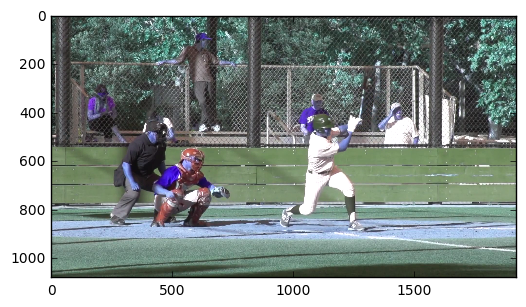

/Users/ninawiedemann/Desktop/UNI/Praktikum/tensor/notebooks/data/Michael_Chavez/000.jpg


In [173]:
"""path = "/Volumes/Nina Backup/videos/atl/2017-04-19/center field/"
vid_example = "490324-0ade0abd-fb64-49ca-aacd-66a50901f538.mp4"
cap = cv2.VideoCapture(path+vid_example)

for i in open(path+vid_example+".dat").readlines():
    datContent=ast.literal_eval(i)

bottom_b=datContent['Batter']['bottom']
left_b=datContent['Batter']['left']
right_b=datContent['Batter']['right']
top_b=datContent['Batter']['top']
bottom_p=datContent['Pitcher']['bottom']
left_p=datContent['Pitcher']['left']
right_p=datContent['Pitcher']['right']
top_p=datContent['Pitcher']['top']
cap.set(cv2.CAP_PROP_POS_FRAMES, 85)
images_pitcher = []
images_batter = []
for i in range(10):
    ret, frame = cap.read()
    images_pitcher.append(frame[top_p:bottom_p, left_p:right_p])
    images_batter.append(frame[top_b:bottom_b, left_b:right_b])"""

def color_box(frame, bbox, color = "red"):
    """
    vid: path to video or image file
    bbox: [oben, unten, links, rechts] bzw [kleineres_y, größeres_y, kleineres_x, größeres_x]
    kann sein dass das bei dir anderes ist, bei mir ist eben die y achse immer die werte umgedreht,
    also oben sind kleinere werte als unten
    """
    # for video:
    #video_capture = cv2.VideoCapture(vid)
    #ret, frame = video_capture.read()
    # for image
    #frame = plt.imread(vid)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(frame, aspect='equal')

    ax.add_patch(
    plt.Rectangle((int(bbox[2]), int(bbox[0])), # linkes oberes eck
                  int(bbox[3]-bbox[2]), # länge von der seite von oben nach unten
                  int(bbox[1]-bbox[0]), fill=False, #länge von der seite von links nach rechts
                  edgecolor=color, linewidth=3.5)
    )
    plt.show()
    
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/batter/"
vid_example = "#11 Mark Mathias (2).mp4"
cap = cv2.VideoCapture(path+vid_example)
with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/center_dics.json", "r") as infile:
    dictionary = json.load(infile)
center = dictionary[vid_example[:-4]]
print(center)
bbox = [center[1]-500, center[1]+300, center[0]-1400, center[0]+100]
cap.set(cv2.CAP_PROP_POS_FRAMES, 255)
fps= cap.get(cv2.CAP_PROP_FPS)
print(fps)
images = []
for i in range(1):#280):
    ret, frame = cap.read()
    #frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    a = frame #[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    #b =frame_gray>200
    plt.imshow(a)
    plt.gray()
    plt.show()
    #images.append(a) #frame_gray[bbox[0]:bbox[1], bbox[2]:bbox[3]])
    #cv2.imwrite("/Users/ninawiedemann/Desktop/UNI/Praktikum/tensor/notebooks/data/Michael_Chavez/%03d.jpg" % i, a)
    if i ==0:
        print("/Users/ninawiedemann/Desktop/UNI/Praktikum/tensor/notebooks/data/Michael_Chavez/%03d.jpg" % i)
    #color_box(frame, bbox)
#bbox = [center[0]]
dic_release_high_quality = {"#31 LHP Michael Chavez (2)": 165, "#00 RHP Devin Smith": 130, "#4 RHP Parker Swindell": 125,
                           "#5 RHP Matt Blais (2)": 335, "#5 RHP Matt Blais (3)":335, "#5 RHP Matt Blais (4)": 138,
                            "#5 RHP Matt Blais (5)": 305, "#5 RHP Matt Blais 5-3 GO (2)": 158, "#5 RHP Matt Blais 5-3 GO": 160,
                            "#8 RHP Cole Johnson (2)": 115, "#8 RHP Cole Johnson": 90, "#9 RHP Ryan King (2)": 170,
                            "#9 RHP Ryan King": 150, "#26 RHP Tim Willites (2)":190, "#26 RHP Tim Willites (3)":158,
                            "#26 RHP Tim Willites": 188, "#31 LHP Michael Chavez (3)": 160, "#31 LHP Michael Chavez":345,
                            "#31 LHP Michael Chavez 5-3 GO": 78, "#42 LHP Michael Chavez": 470, "#45 LHP Steffen Simmons (2)":230,
                            "#45 LHP Steffen Simmons": 230, "#48 RHP Tom Flippin 6-3 GO": 525, "#48 RHP Tom Flippin": 282,
                            "Menlo Park Legends #98 RHP Zac Grotz":290, "#5 RHP Matt Blais": 252}
with open("dic_release_high_quality.json", "w") as outfile:
    json.dump(dic_release_high_quality, outfile)

In [ ]:
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/"
vid_example = "pitcher/#31 LHP Michael Chavez (2).mp4"

def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
            "right_eye", "right_ear","left_eye", "left_ear", "nose ", "neck"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)

    return np.array(liste)



bbox = [center[1]-400, center[1]+300, center[0]-1100, center[0]]

joints_array = from_json(path+"outputs_example/"+"#31 LHP Michael Chavez (2)_joints.json")
print(joints_array.shape)
print("ellbow wrist", joints_array[160, 4:6])

cap = cv2.VideoCapture(path+vid_example)

cap.set(cv2.CAP_PROP_POS_FRAMES, 160)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 200,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame_in = cap.read()
old_frame = old_frame_in#[bbox[0]:bbox[1], bbox[2]:bbox[3]]
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
#print(p0)
#p0 = np.roll(np.array([[joints_array[160,4]], [joints_array[160,5]]]), 1, axis = 2)
#print(p0)
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)


j=0
while j<10:
    ret,frame_in = cap.read()
    frame = frame_in#[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    
    
    plt.figure(figsize = (20,10))
    plt.imshow(img)
    plt.show()
    

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
    j+=1

plt.figure(figsize = (20,10))
plt.imshow(img)
plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
a = images[2] #np.zeros((200,200))
#a[50:150,50:150]=1
window_size = 100
maxi = np.inf
maxi_ind = (i,j)
maxi_img = []
var_img = []
for i in range(window_size//2, len(a)-window_size//2, 3):
    maxi_img_inner = []
    var_img_inner = []
    for j in range(window_size//2, len(a[0])-window_size//2, 3):
        # print(i,j)
        patch = a[i-window_size//2:i+window_size//2, j-window_size//2:j+window_size//2]
        blur = cv2.Laplacian(patch, cv2.CV_64F).var()
        var_img_inner.append(np.std(patch))
        maxi_img_inner.append(blur)
        if blur<maxi:
            maxi= blur
            maxi_ind = (i,j)
    maxi_img.append(maxi_img_inner)
    var_img.append(var_img_inner)

print(maxi_ind)
#print(maxi_img)
#print(cv2.Laplacian(a, cv2.CV_64F).var())

In [ ]:
#print(var_img)
var_img = np.array(var_img)
plt.imshow(var_img)
plt.show()
var_img_new = var_img/np.max(var_img)
maxi_img = np.array(maxi_img)
#maxi_img = 20-maxi_img
#maxi_img[maxi_img<0]==0
plt.imshow(maxi_img)
plt.show()
maxi_img_new = 1-(maxi_img/np.max(maxi_img))
result = (maxi_img_new+var_img_new)/2
plt.imshow(result)
plt.show()

In [ ]:
from scipy import ndimage
for i, img in enumerate(images):
    img = ndimage.filters.gaussian_filter(img, sigma = 20)
    if i>0:
        diff = np.absolute(before-img)
        diff_smooth = ndimage.filters.gaussian_filter(diff, sigma = 20)
        #print(diff)
        plt.imshow(diff_smooth)
        plt.show()
    before = img

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sp
import scipy.stats
import json
from os import listdir
import cv2
import ast
import json
from run_thread import Runner
from test import test
import matplotlib.pylab as plt
#from notebooks.code_to_json import from_json

from data_preprocess import JsonProcessor

def shift_data(data, labels, max_shift=30):
    new_data=[]
    for i in range(len(data)):
        shift = np.random.randint(-max_shift, max_shift)
        new = np.roll(data[i], shift, axis=0)
        labels[i] = labels[i]+shift-max_shift
        new_data.append(new[max_shift:len(new)-max_shift])
    return np.array(new_data), labels

def flip_x_data(data):
    for i in range(len(data)):
        mean = np.mean(data[i, :, :, 0])
        flipped = (data[i, :,:,0]-mean)*(-1)
        flipped+=mean
        data[i,:,:,0] = flipped
    return data

def get_test_data(inp_dir,  sequ_len, start, labels=None):
    #sequ_len=150
    data = []

    filenames = []
    for files in listdir(inp_dir):
        name = files.split(".")[0]
        if name+".mp4" in listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"):
            prepro = JsonProcessor()
            array = prepro.from_json(inp_dir+files)
            if labels is None:
                if len(array)>start+sequ_len:
                    data.append(array[start:start+sequ_len])
                    filenames.append(name)
            else:
                real = labels[name]
                data.append(array[real-70:real+30])
                filenames.append(name)
    return np.array(data), filenames

def testing(save_path, sequ_len=100, start = 80):
    with open("dic_release_high_quality.json", "r") as outfile:
        dic_release_high_quality = json.load(outfile)
    data, files = get_test_data("/Volumes/Nina Backup/high_quality_outputs/", sequ_len, start, labels=dic_release_high_quality)
    
    np.save("/Volumes/Nina Backup/testing_data.npy", data)
    data = (data-np.mean(data))/np.std(data)
    plot_data = np.swapaxes(data, 0,1)
    plt.figure(figsize=(20,10))
    plt.plot(plot_data[:,:,0,0])
    plt.show()
    plt.figure(figsize=(20,10))
    plt.plot(plot_data[:,:,0,1])
    plt.show()
    #lab, out = test(data, save_path)
    for i in range(len(files)):
        try:
            real = dic_release_high_quality[files[i]]
            if real>start+sequ_len or real<start:
                print("output", lab[i], "but sequence was not containing release frame")
            else:
                print("output", lab[i], "real label: ", real-start)
        except KeyError:
            print("output", lab[i], "no real available")

def training(save_path, sequ_len = 100, max_shift=30):

    prepro = JsonProcessor()
    data, plays = prepro.get_data([["/Volumes/Nina Backup/outputs_old/old_videos/cf/", "/Volumes/Nina Backup/outputs_old/new_videos/cf/"], ["/Volumes/Nina Backup/outputs/old_videos/sv/"]], sequ_len+2*max_shift)
    label = prepro.get_label_release(plays, "/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data_cut.csv", "pitch_frame_index", cut_off_min=70, cut_off_max=110)
    inds = np.where(label==0)[0]
    print(inds)
    data = np.delete(data, inds, axis = 0)
    label = np.delete(label, inds, axis=0)
    print(data.shape, len(label), np.any(label==0))

    data_old, label = shift_data(data, label, max_shift=max_shift)
    print(data_old.shape)
    data_new = flip_x_data(data_old.copy())
    print(data_new.shape)
    data = np.append(data_new, data_old, axis=0)
    label = np.append(label, label)
    print(data.shape)
    
    np.save("/Volumes/Nina Backup/training_data.npy", data)
    plot_data = ((data-np.mean(data))/np.std(data))[:50]
    plot_data = np.swapaxes(plot_data, 0,1)
    plt.figure(figsize=(20,10))
    plt.plot(plot_data[:,:,0,0])
    plt.show()
    plt.figure(figsize=(20,10))
    plt.plot(plot_data[:,:,0,1])
    plt.show()

    runner = Runner(data, np.reshape(label, (-1, 1)), SAVE = save_path, BATCH_SZ=40, EPOCHS = 300, batch_nr_in_epoch = 50,
            act = tf.nn.relu, rate_dropout = 0,
            learning_rate = 0.0005, nr_layers = 4, n_hidden = 128, optimizer_type="adam", regularization=0,
            first_conv_filters=12, first_conv_kernel=3, second_conv_filter=12,
            second_conv_kernel=3, first_hidden_dense=128, second_hidden_dense=56,
            network = "combined")
    runner.unique = [sequ_len-2*max_shift]
    runner.start()

save =  "/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/saved_models/release_frame_combined"
training(save, sequ_len=100)


In [159]:
training_data = np.load("/Volumes/Nina Backup/training_data.npy")
testing_data = np.load("/Volumes/Nina Backup/testing_data.npy")

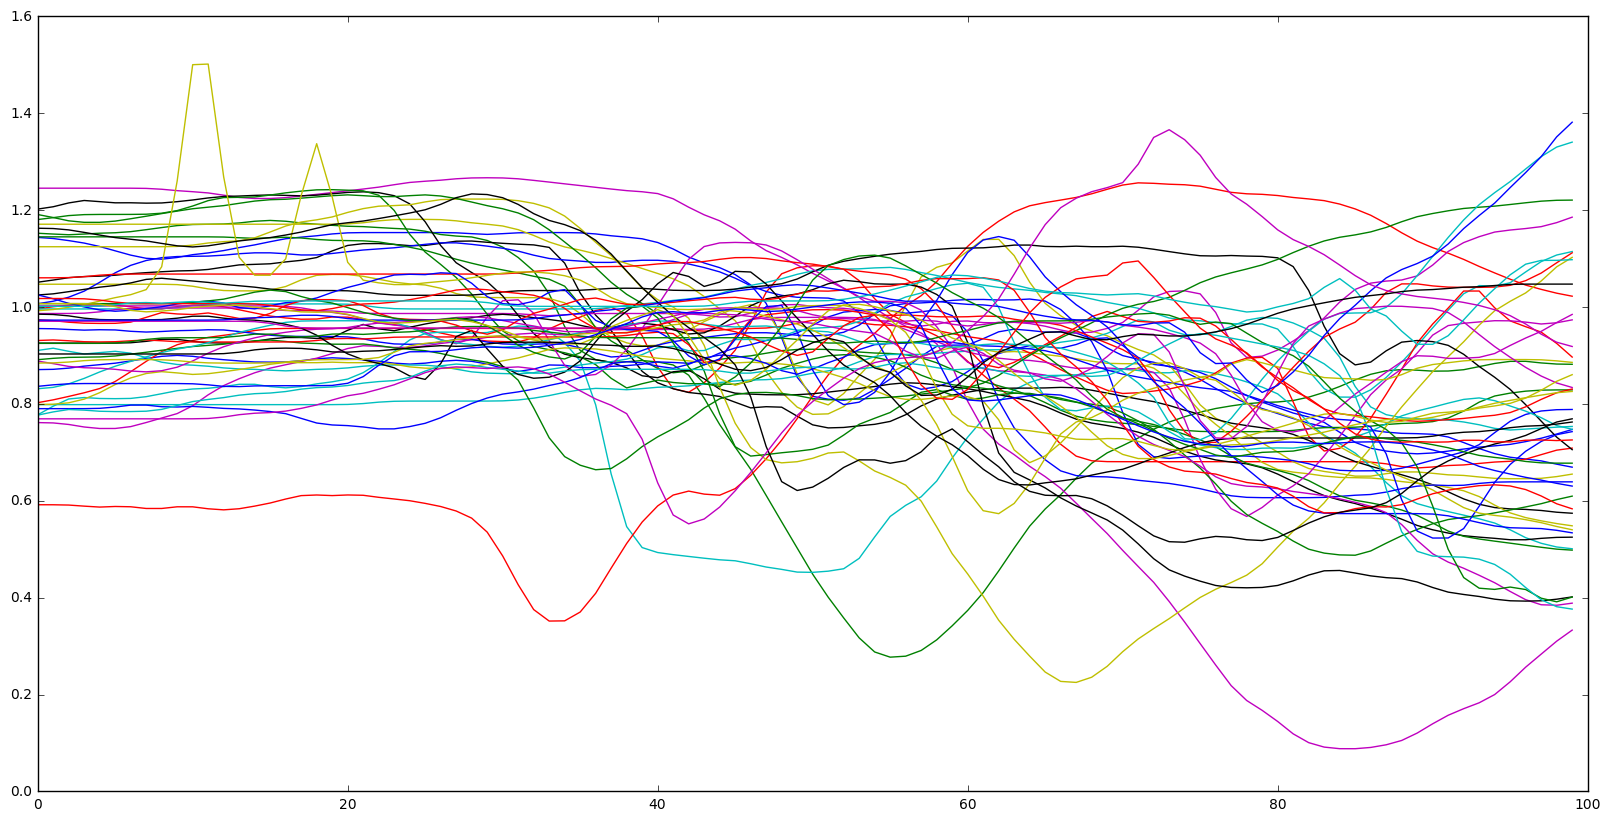

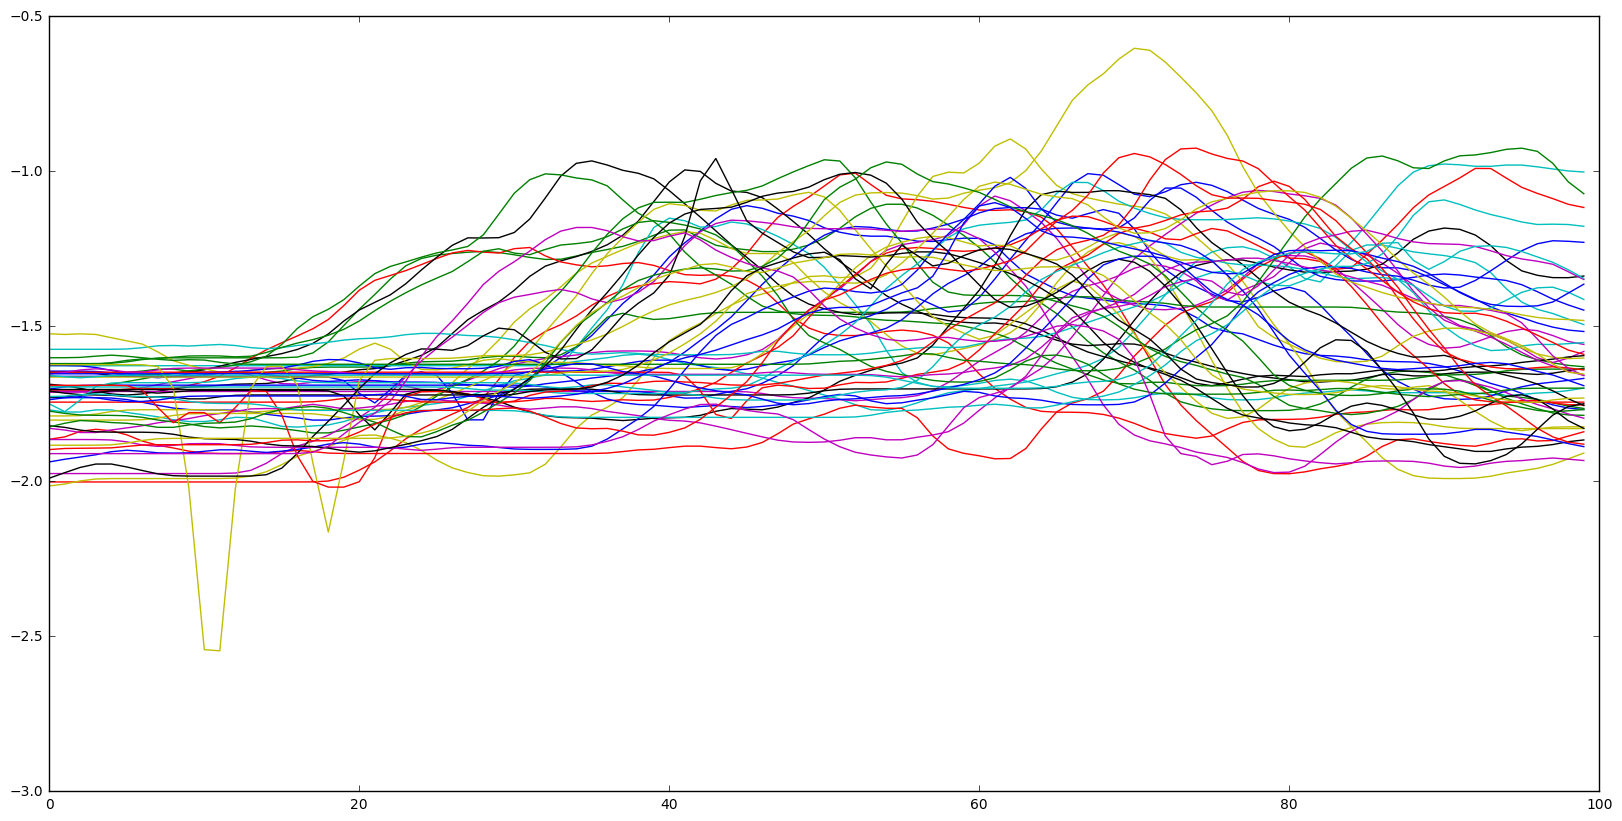

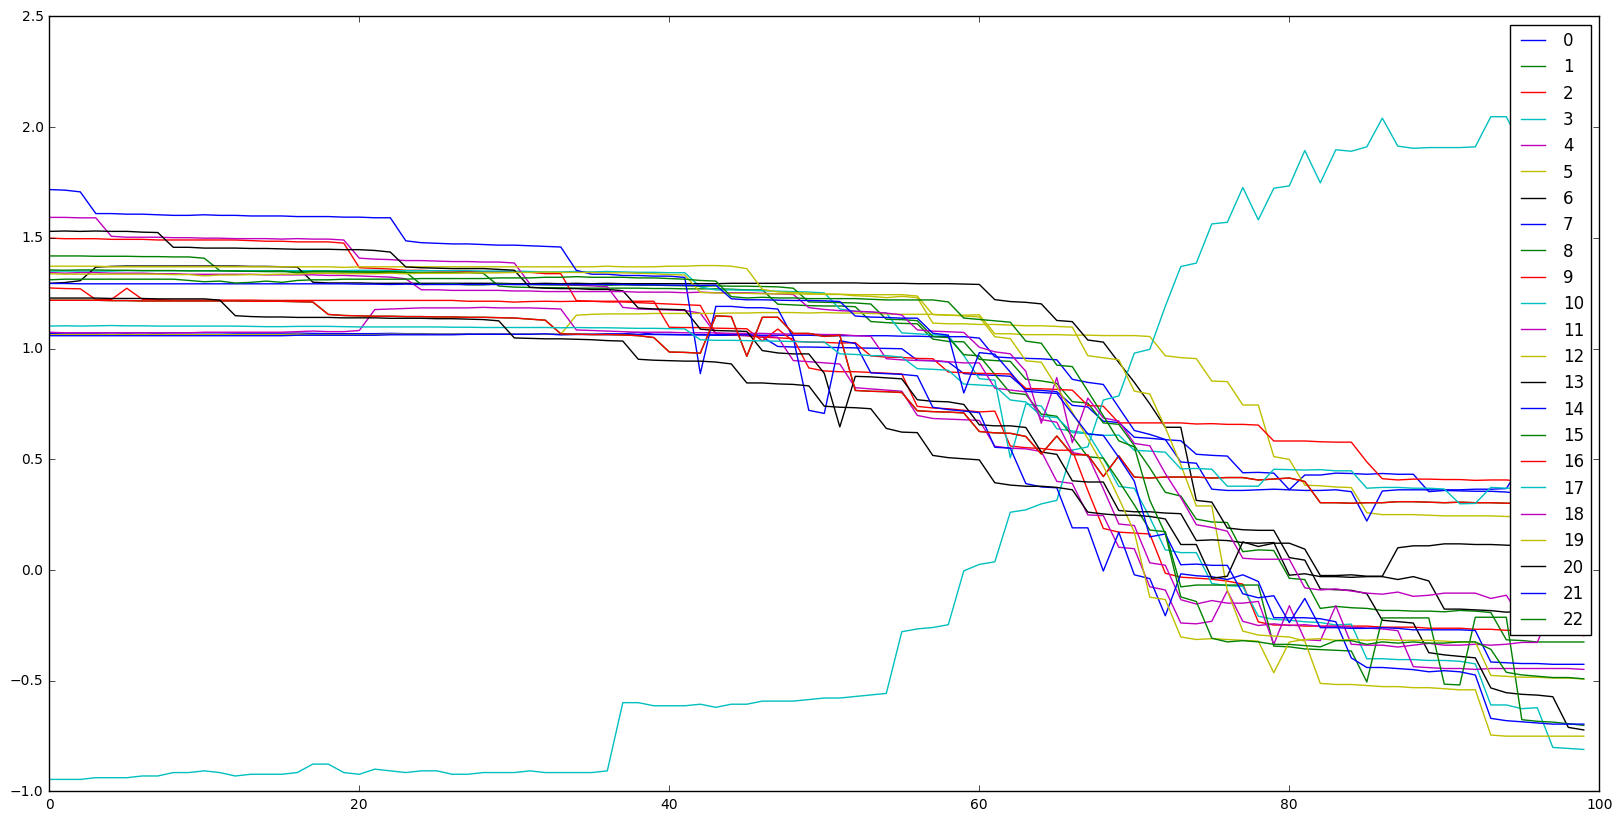

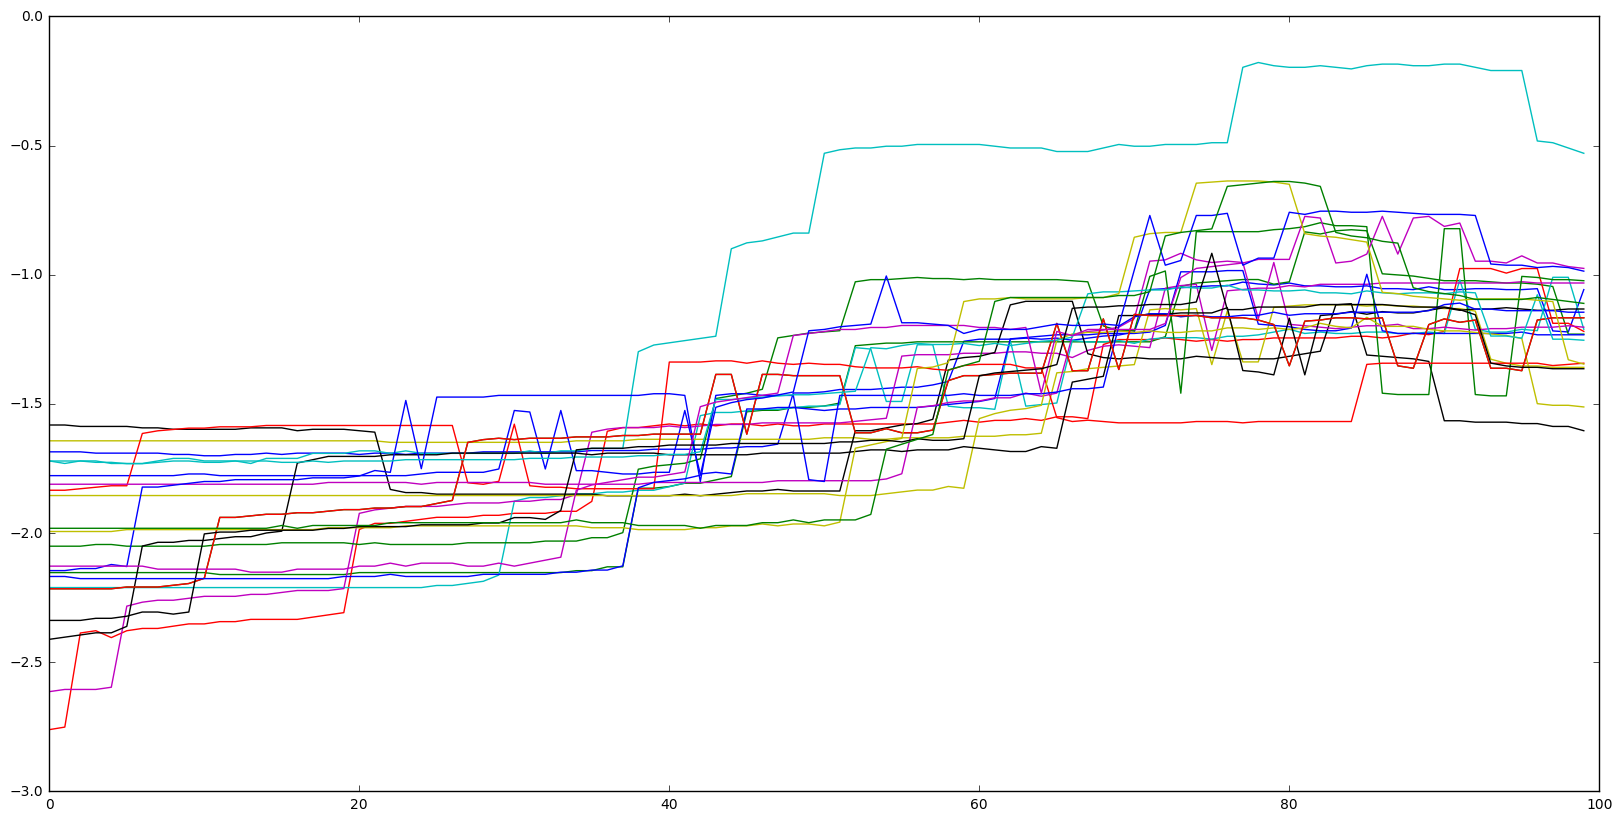

In [171]:
#print(testing_data)

def norm0(data):
    return (data-np.mean(data))/np.std(data)
def norm1(data):
    # per example
    norm = data.copy()
    for i, exp in enumerate(data):
        norm[i] = (exp-np.mean(exp))/np.std(exp)
    return norm
def norm2(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))
def norm3(data):
    # per trajectory
    means = np.mean(data, axis = 1)
    stds = np.mean(data, axis = 1)
    new = [(data[:,i]- means)/stds for i in range(len(data[0]))]
    return np.swapaxes(new, 0,1)
def norm4(data):
    #log transform
    log_transformed = np.log(data)
    #print(log_transformed)
    return norm1(log_transformed)
smooth_data = scipy.ndimage.filters.gaussian_filter1d(training_data, axis = 1, sigma = 1)
plot_data = norm4(smooth_data)[:50]
plot_data = np.swapaxes(plot_data, 0,1)
plt.figure(figsize=(20,10))
plt.plot(plot_data[:,:,0,0])
plt.show()
plt.figure(figsize=(20,10))
plt.plot(plot_data[:,:,0,1])
plt.show()
    
"""
for i in range(len(testing_data)):
    for j in range(len(testing_data[0])):
        for k in range(len(testing_data[0,0])):
            for l in range(2):
                if testing_data[i,j,k, l]==0:
                    print(i,j,k,l)
"""
    #print(np.any(testing_data==0))
plot_data = norm4(a)
plot_data = np.swapaxes(plot_data, 0,1)
plt.figure(figsize=(20,10))
for i in range(len(plot_data[0])): 
    plt.plot(plot_data[:,i,0,0], label = i)
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(plot_data[:,:,0,1])
plt.show()

In [166]:
a = np.delete(testing_data, [9,19, 22], axis =0)
print(a.shape, testing_data.shape)

(23, 100, 12, 2) (26, 100, 12, 2)
